1. Select a topic related to human behavior that interests you and can be measured over time. (Examples include: Social media usage patterns, Sleep habits and quality, Exercise frequency and intensity, Mood fluctuations, Consumer spending habits,Academic performance over a school year)





2. To gather the data, you can use publicly available datasets or collect data yourself (e.g., tracking your own grades)



3. Choose an appropriate time series analysis model for your data. (ARIMA/ Exponential smoothing methods/ LSTM neural networks)

4. Apply the chosen model to the data and interpret the results. Consider Trends, Seasonality, Cyclical patterns, Anomalies or outliers
    Based on your analysis, what insights can you derive about the behavioral topic? How might these findings be applied in real-world scenarios?

One of the hurdles I faced in the behaviour of my data has to do with my datasets limitations. I chose an LSTM model because I could view the daily transactions/sales which could reflect weekly revenue. This was definitely effective as I was able to view the times of day where people typically bought coffee (8am-10am). In the behaviour of my data the seasons are somewhat accurate seeing January is typically a slow time in business between retail and resturaunts because of the holidays. But the data is limited given the months reflected are between January of 2023 - June 2023 which doesn't give a full reflection of how sales increase during some of the busiest months of the year.
Overall I found the data was accurate as the sales increased as far as the daily threshold of sales goes on a weekly basis. January being the slowest time and June increasing making the threshold more practical.
Besides the limitation of the dataset and the seasons I found the performance of the training and testing sets to be a good learning experience, where I got the testing and training to be neck and neck as far as accuracy goes through the method of shuffling and splitting the data during training. This helped eliminate false positives during testing, and I found the performance of the model on the data to be fairly accurate overall.
I appriciated I could change the time frame as far as scaling the data to a given time period for the prediction. I did train on a sliding scale of 14 days and found the model was more accurate on the daily sales prediction using only 4.
Given the behaviour of the model is accurate some of the other real world applications someone could use this for would be scheduling, would someone need to minimize how many people work in a coffee shop knowing when business is slow, or possibly hiring temporary workers during the holidays as different events come into the town or the seasonal sales bring in a loot of customers a frugal staff could not handle without the extra help.
Overall I believe the model captured some valuble trends where a Coffee Roasting company could benefit from the understood trends. And, if there was a need to expand the company would be used to operating at a certain capacity given seasonal trends and preperation. If a company knows their weekly revenue and wants to keep a certain threshold, the company can know when or how it can expand, or how much it can reinvest in new persuits for different seasonal campains to possibly create new possible streams of income.
The results and experience of training on this data set (even if it was simulated) was a great one!

## Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

## Preparing Dataframe

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('Coffee-Shop-Sales.csv')
df

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/2023,7:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/2023,7:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/2023,7:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/2023,7:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/2023,7:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,6/30/2023,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg
149112,149453,6/30/2023,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg
149113,149454,6/30/2023,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg
149114,149455,6/30/2023,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino


In [5]:
# Convert 'transaction_date' to datetime and check order
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%m/%d/%Y')
df['transaction_cost'] = df['transaction_qty'] * df['unit_price']
print(df[['transaction_date', 'transaction_time', 'transaction_cost']].head(1000))

    transaction_date transaction_time  transaction_cost
0         2023-01-01          7:06:11              6.00
1         2023-01-01          7:08:56              6.20
2         2023-01-01          7:14:04              9.00
3         2023-01-01          7:20:24              2.00
4         2023-01-01          7:22:41              6.20
..               ...              ...               ...
995       2023-01-02         17:15:35              6.20
996       2023-01-02         17:17:00              6.00
997       2023-01-02         17:17:00              3.25
998       2023-01-02         17:18:25              6.00
999       2023-01-02         17:19:03              2.50

[1000 rows x 3 columns]


In [6]:
# aggregating the data by day
daily_data = df.groupby('transaction_date').agg(
    total_revenue=('transaction_cost', 'sum'),
    transaction_count=('transaction_id', 'count')
).reset_index()
daily_data['day_of_week'] = pd.to_datetime(daily_data['transaction_date']).dt.dayofweek  # 0=Monday
daily_data = daily_data.sort_values('transaction_date').reset_index(drop=True)

daily_data

,transaction_date,total_revenue,transaction_count,day_of_week
0,2023-01-01,2508.20,550,6
1,2023-01-02,2403.35,566,0
2,2023-01-03,2565.00,582,1
3,2023-01-04,2220.10,497,2
4,2023-01-05,2418.85,547,3
...,...,...,...,...
176,2023-06-26,5875.90,1195,0
177,2023-06-27,5975.65,1277,1
178,2023-06-28,4728.90,1070,2
179,2023-06-29,4450.75,1009,3


In [7]:
# setting threshold
threshold = daily_data['total_revenue'].quantile(0.70)  # Adjust percentile
print(threshold)

# adding target column based on threshold and next day's revenue
daily_data['target'] = (daily_data['total_revenue'].shift(-1) > threshold).astype(int)
daily_data = daily_data[:-1]
daily_data

4598.9


,transaction_date,total_revenue,transaction_count,day_of_week,target
0,2023-01-01,2508.20,550,6,0
1,2023-01-02,2403.35,566,0,0
2,2023-01-03,2565.00,582,1,0
3,2023-01-04,2220.10,497,2,0
4,2023-01-05,2418.85,547,3,0
...,...,...,...,...,...
175,2023-06-25,5754.85,1174,6,1
176,2023-06-26,5875.90,1195,0,1
177,2023-06-27,5975.65,1277,1,1
178,2023-06-28,4728.90,1070,2,0


from matplotlib import pyplot as plt
daily_data['total_revenue'].plot(kind='hist', bins=20, title='total_revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data['transaction_count'].plot(kind='hist', bins=20, title='transaction_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data['day_of_week'].plot(kind='hist', bins=20, title='day_of_week')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data.plot(kind='scatter', x='total_revenue', y='transaction_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data.plot(kind='scatter', x='transaction_count', y='day_of_week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_data.plot(kind='scatter', x='day_of_week', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['total_revenue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('total_revenue')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['transaction_count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('transaction_count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['day_of_week']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('day_of_week')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['target']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('target')

from matplotlib import pyplot as plt
daily_data['total_revenue'].plot(kind='line', figsize=(8, 4), title='total_revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
daily_data['transaction_count'].plot(kind='line', figsize=(8, 4), title='transaction_count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
daily_data['day_of_week'].plot(kind='line', figsize=(8, 4), title='day_of_week')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
daily_data['target'].plot(kind='line', figsize=(8, 4), title='target')
plt.gca().spines[['top', 'right']].set_visible(False)

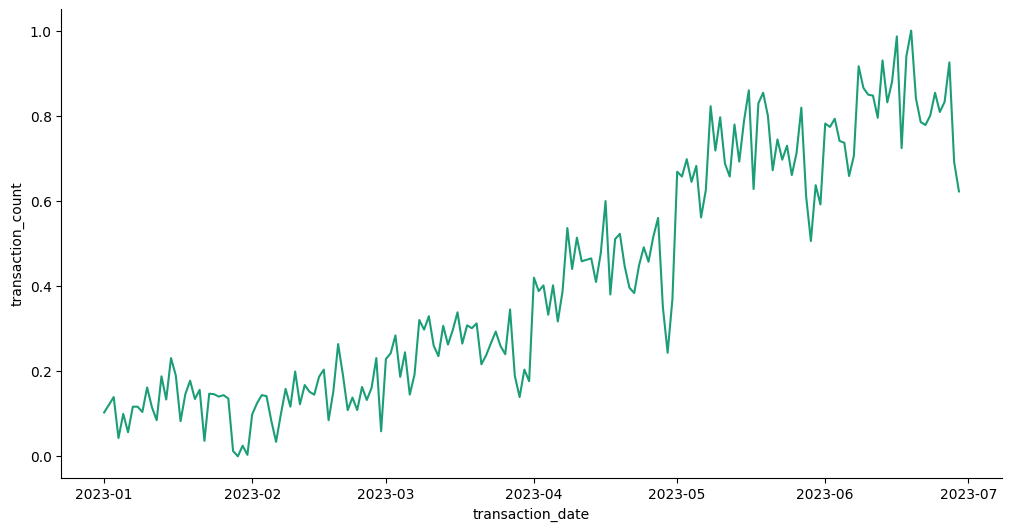

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['transaction_count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('transaction_count')

## Preparing Input for Model

In [8]:
# checking for missing dates
# Generate full date range
full_dates = pd.date_range(
    start=daily_data['transaction_date'].min(),
    end=daily_data['transaction_date'].max(),
    freq='D'  # Daily
)

# Find missing dates
missing_dates = full_dates.difference(daily_data['transaction_date'])
print(f"Missing dates: {len(missing_dates)}")
print(missing_dates.tolist()[:5])

Missing dates: 0
[]


In [9]:
# normalize features
features = ['total_revenue', 'transaction_count', 'day_of_week']
scaler = MinMaxScaler()
daily_data[features] = scaler.fit_transform(daily_data[features])


/tmp/ipython-input-9-2828225236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data[features] = scaler.fit_transform(daily_data[features])


In [10]:
daily_data

,transaction_date,total_revenue,transaction_count,day_of_week,target
0,2023-01-01,0.107882,0.102941,1.000000,0
1,2023-01-02,0.083871,0.121041,0.000000,0
2,2023-01-03,0.120889,0.139140,0.166667,0
3,2023-01-04,0.041907,0.042986,0.333333,0
4,2023-01-05,0.087421,0.099548,0.500000,0
...,...,...,...,...,...
175,2023-06-25,0.851365,0.808824,1.000000,1
176,2023-06-26,0.879086,0.832579,0.000000,1
177,2023-06-27,0.901928,0.925339,0.166667,1
178,2023-06-28,0.616423,0.691176,0.333333,0


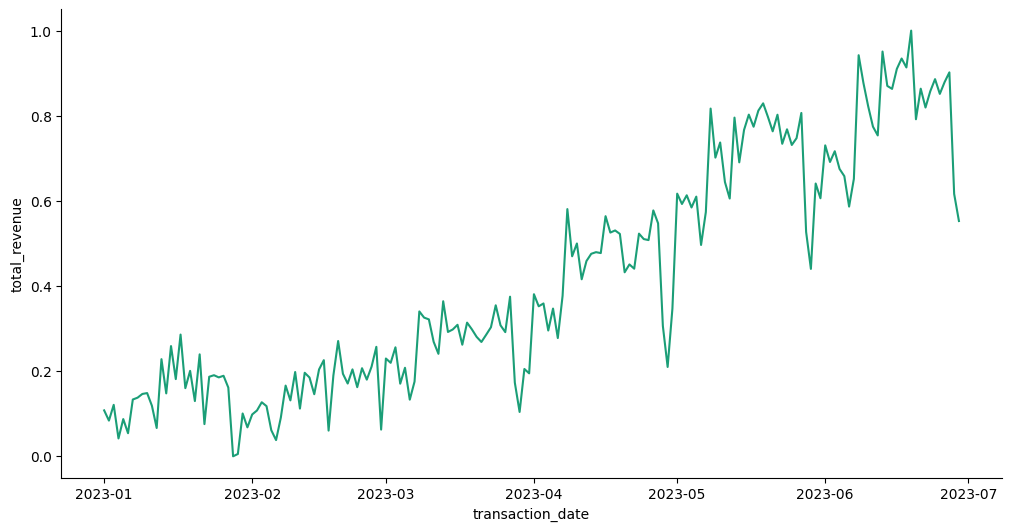

In [42]:
# @title transaction_date vs total_revenue

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['transaction_date']
  ys = series['total_revenue']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_data.sort_values('transaction_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('transaction_date')
_ = plt.ylabel('total_revenue')

In [11]:
# creating sequences
sequence_length = 7  # Using 2 weeks of history
X, y = [], []

for i in range(len(daily_data) - sequence_length):
    X.append(daily_data.iloc[i:i+sequence_length][features].values)
    y.append(daily_data.iloc[i+sequence_length]['target'])

X = np.array(X)
y = np.array(y)

In [12]:
print(y.shape)
y

(173,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [13]:
print(X.shape)
print(X[0])
print(X[0][0])
print(X[0][2][2])

(173, 7, 3)
[[0.10788196 0.10294118 1.        ]
 [0.08387129 0.12104072 0.        ]
 [0.12088916 0.13914027 0.16666667]
 [0.04190702 0.04298643 0.33333333]
 [0.08742079 0.09954751 0.5       ]
 [0.05421578 0.05656109 0.66666667]
 [0.13340402 0.11651584 0.83333333]]
[0.10788196 0.10294118 1.        ]
0.16666666666666666


In [14]:
X

array([[[0.10788196, 0.10294118, 1.        ],
        [0.08387129, 0.12104072, 0.        ],
        [0.12088916, 0.13914027, 0.16666667],
        ...,
        [0.08742079, 0.09954751, 0.5       ],
        [0.05421578, 0.05656109, 0.66666667],
        [0.13340402, 0.11651584, 0.83333333]],

       [[0.08387129, 0.12104072, 0.        ],
        [0.12088916, 0.13914027, 0.16666667],
        [0.04190702, 0.04298643, 0.33333333],
        ...,
        [0.05421578, 0.05656109, 0.66666667],
        [0.13340402, 0.11651584, 0.83333333],
        [0.13772754, 0.11651584, 1.        ]],

       [[0.12088916, 0.13914027, 0.16666667],
        [0.04190702, 0.04298643, 0.33333333],
        [0.08742079, 0.09954751, 0.5       ],
        ...,
        [0.13340402, 0.11651584, 0.83333333],
        [0.13772754, 0.11651584, 1.        ],
        [0.14644786, 0.1040724 , 0.        ]],

       ...,

       [[0.79178164, 0.84049774, 0.16666667],
        [0.86362356, 0.78506787, 0.33333333],
        [0.81936242, 0

In [15]:
# test/train split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
from sklearn.model_selection import train_test_split

# Shuffle & split in one step (recommended)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 20% test
    shuffle=True,    # Shuffle before splitting
    random_state=42 # For reproducibility
)

In [17]:
X_train.shape

(138, 7, 3)

## Model Architecture and Training

In [18]:
# defining the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# dropout layer
# extra LSTM layers
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# model = tf.keras.Sequential([
#    tf.keras.layers.LSTM(64, input_shape=()),
#    drop out layer
#    extra LSTM layers
#    tf.keras.layers.Dense(1)
#])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# defining the model
model0 = Sequential()
model0.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model0.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# dropout layer
# extra LSTM layers
model0.add(Dense(units=1))
model0.compile(loss='mean_squared_error', optimizer='adam')

# model = tf.keras.Sequential([
#    tf.keras.layers.LSTM(64, input_shape=()),
#    drop out layer
#    extra LSTM layers
#    tf.keras.layers.Dense(1)
#])

In [20]:
# Training the model
model0.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
138/138 - 3s - 24ms/step - loss: 0.1616
Epoch 2/100
138/138 - 1s - 4ms/step - loss: 0.1036
Epoch 3/100
138/138 - 1s - 5ms/step - loss: 0.0909
Epoch 4/100
138/138 - 1s - 4ms/step - loss: 0.0866
Epoch 5/100
138/138 - 1s - 5ms/step - loss: 0.0799
Epoch 6/100
138/138 - 1s - 5ms/step - loss: 0.0735
Epoch 7/100
138/138 - 1s - 4ms/step - loss: 0.0698
Epoch 8/100
138/138 - 1s - 4ms/step - loss: 0.0791
Epoch 9/100
138/138 - 1s - 4ms/step - loss: 0.0773
Epoch 10/100
138/138 - 1s - 6ms/step - loss: 0.0678
Epoch 11/100
138/138 - 1s - 9ms/step - loss: 0.0621
Epoch 12/100
138/138 - 1s - 4ms/step - loss: 0.0605
Epoch 13/100
138/138 - 1s - 5ms/step - loss: 0.0578
Epoch 14/100
138/138 - 1s - 9ms/step - loss: 0.0716
Epoch 15/100
138/138 - 1s - 5ms/step - loss: 0.0534
Epoch 16/100
138/138 - 1s - 9ms/step - loss: 0.0590
Epoch 17/100
138/138 - 1s - 4ms/step - loss: 0.0527
Epoch 18/100
138/138 - 1s - 4ms/step - loss: 0.0464
Epoch 19/100
138/138 - 1s - 5ms/step - loss: 0.0543
Epoch 20/100
138/138

In [21]:
# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
138/138 - 1s - 11ms/step - loss: 0.1405
Epoch 2/100
138/138 - 0s - 3ms/step - loss: 0.0986
Epoch 3/100
138/138 - 0s - 4ms/step - loss: 0.0870
Epoch 4/100
138/138 - 1s - 4ms/step - loss: 0.0872
Epoch 5/100
138/138 - 1s - 5ms/step - loss: 0.0823
Epoch 6/100
138/138 - 1s - 9ms/step - loss: 0.0745
Epoch 7/100
138/138 - 0s - 4ms/step - loss: 0.0711
Epoch 8/100
138/138 - 1s - 4ms/step - loss: 0.0749
Epoch 9/100
138/138 - 0s - 4ms/step - loss: 0.0711
Epoch 10/100
138/138 - 1s - 4ms/step - loss: 0.0694
Epoch 11/100
138/138 - 0s - 4ms/step - loss: 0.0716
Epoch 12/100
138/138 - 0s - 3ms/step - loss: 0.0654
Epoch 13/100
138/138 - 0s - 3ms/step - loss: 0.0712
Epoch 14/100
138/138 - 1s - 4ms/step - loss: 0.0657
Epoch 15/100
138/138 - 1s - 4ms/step - loss: 0.0654
Epoch 16/100
138/138 - 1s - 5ms/step - loss: 0.0631
Epoch 17/100
138/138 - 1s - 4ms/step - loss: 0.0625
Epoch 18/100
138/138 - 0s - 3ms/step - loss: 0.0621
Epoch 19/100
138/138 - 0s - 3ms/step - loss: 0.0630
Epoch 20/100
138/138

## Model Evaluation

In [22]:
# First, compile the model with named metrics
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    # metrics=[]  # No specific metrics needed for basic regression evaluation
)

# Then evaluate - now results will be a list
results = model.evaluate(X_test, y_test, verbose=0)

# Print metrics with proper indexing
print(f"""
Test Metrics:
- Loss: {results:.2f}
""")

# Evaluate
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results:.2f}")


Test Metrics:
- Loss: 0.34

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3410
Test Loss: 0.34


In [23]:
# Then evaluate - now results will be a list
results = model0.evaluate(X_test, y_test, verbose=0)

# Print metrics with proper indexing
print(f"""
Test Metrics:
- Loss: {results:.2f}
""")

# Evaluate
results = model0.evaluate(X_test, y_test)
print(f"Test Loss: {results:.2f}")


Test Metrics:
- Loss: 0.36

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3603
Test Loss: 0.36


In [24]:
X_test[0]

array([[0.75377678, 0.79524887, 0.        ],
       [0.95086802, 0.92986425, 0.16666667],
       [0.87006762, 0.83144796, 0.33333333],
       [0.8631335 , 0.8800905 , 0.5       ],
       [0.91012203, 0.98642534, 0.66666667],
       [0.93443498, 0.7239819 , 0.83333333],
       [0.91347918, 0.94004525, 1.        ]])

In [25]:
prediction = model0.predict(np.expand_dims(X_test[10], axis=0))
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


array([[[0.93211824],
        [0.8089345 ],
        [0.77770483],
        [0.80438167],
        [0.80905074],
        [0.80809706],
        [0.81728935]]], dtype=float32)

In [26]:
y_train

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0])

In [27]:
y_test

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])